# Import libraries

In [1]:
import os
os.chdir('/home/wcx/gitProject/evoxbench/evoxbench_submit/c10mop1/')

import h5py
import pickle
import random
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from benchmark_c10_mop1 import C10MOPProblem, c10mop

Auto Configuration Succeed!, Using database /home/wcx/gitProject/evoxbench/database/database.
Auto Configuration Succeed!, Using database /home/wcx/gitProject/evoxbench/database/database.
['/home/wcx/gitProject/evoxbench/evoxbench_submit/pymoo060', '/home/wcx/gitProject/evoxbench/evoxbench_submit', '/sdb_new/gitProject/evoxbench/evoxbench_submit/c10mop1', '/home/wcx/anaconda3/envs/evoxbench/lib/python38.zip', '/home/wcx/anaconda3/envs/evoxbench/lib/python3.8', '/home/wcx/anaconda3/envs/evoxbench/lib/python3.8/lib-dynload', '', '/home/wcx/.local/lib/python3.8/site-packages', '/home/wcx/anaconda3/envs/evoxbench/lib/python3.8/site-packages', '/home/wcx/gitProject/evoxbench/database/database', '/home/wcx/gitProject/evoxbench/database/database']


In [3]:
args = edict()
args.run = 2
args.seed = args.run
args.pid = 1

In [3]:
# set seed
random.seed(args.seed)
np.random.seed(args.seed)

In [4]:
benchmark = c10mop(args.pid)
problem = C10MOPProblem(benchmark, args.pid)

# Divide the dataset

In [5]:
d = './traindata/'
obj_d = d + 'c10mop1_train_data_200000_{:02d}.pkl'.format(args.run)
if not os.path.exists(obj_d):
    print('generating data')
    search_space = benchmark.search_space
    evaluator = benchmark.evaluator
    archs = np.array(search_space.sample(200000))
    X = search_space.encode(archs)
    # about 17000 valid archs in 200000 archs
    fine_idx = problem._get_fine_x(X)
    X, archs = X[fine_idx], archs[fine_idx]
    y = evaluator.evaluate(archs, true_eval=True)
    pickle.dump((X, y), open(obj_d, 'wb')) 
else:
    X, y = pickle.load(open(obj_d, 'rb'))

In [6]:
print(len(X))

17384


<AxesSubplot: ylabel='Count'>

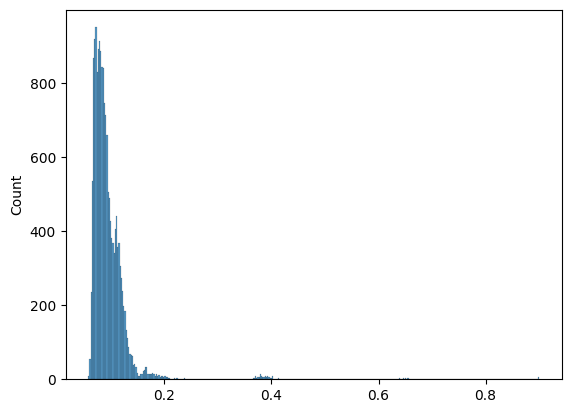

In [7]:
sns.histplot([i['err'] for i in y])

# Train the accuracy model

In [8]:
def aux_acc(train_x, train_y):
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from catboost import CatBoostRegressor, Pool
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=2023)

    models, errs = [], []
    X, y = train_x, train_y
    for train_idx, test_idx in kfold.split(X, y):
        # robust parameters
        model = CatBoostRegressor(iterations=10000, learning_rate=0.1, depth=6, random_seed=2023,
                                loss_function='RMSE', verbose=True, early_stopping_rounds=1000)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train, eval_set=Pool(X_test, y_test), use_best_model=True, verbose=500)
        
        y_pred = model.predict(X_test)
        models.append(model)
        
        err = mean_squared_error(y_test, y_pred)
        errs.append(err)

    return models, errs

In [9]:
# trainset and testset
## testset is not used, using 5-fold cross validation to evaluate the model
train_len = 5000
train_x, train_y = X[:train_len], y[:train_len]
test_x, test_y = X[train_len:], y[train_len:]
print('train data shape: ', train_x.shape, '\ntest data shape: ', test_x.shape)

trn_x = train_x
trn_y = np.array([i['err'] for i in train_y])
tst_x = test_x
tst_y = np.array([i['err'] for i in test_y])
err_models, mse_errs = aux_acc(trn_x, trn_y)

train data shape:  (5000, 26) 
test data shape:  (12384, 26)
0:	learn: 0.0381783	test: 0.0337034	best: 0.0337034 (0)	total: 51.4ms	remaining: 8m 33s
500:	learn: 0.0148966	test: 0.0277939	best: 0.0271372 (215)	total: 986ms	remaining: 18.7s
1000:	learn: 0.0087352	test: 0.0285399	best: 0.0271372 (215)	total: 1.88s	remaining: 16.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.02713724785
bestIteration = 215

Shrink model to first 216 iterations.
0:	learn: 0.0379332	test: 0.0349286	best: 0.0349286 (0)	total: 2.98ms	remaining: 29.8s
500:	learn: 0.0139605	test: 0.0309018	best: 0.0287197 (87)	total: 900ms	remaining: 17.1s
1000:	learn: 0.0080685	test: 0.0318354	best: 0.0287197 (87)	total: 1.8s	remaining: 16.2s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.02871965358
bestIteration = 87

Shrink model to first 88 iterations.
0:	learn: 0.0366410	test: 0.0400761	best: 0.0400761 (0)	total: 4.01ms	remaining: 40.1s
500:	learn: 0.0141184	test: 0.0338015	

In [10]:
# evaluate the model in testset 
## testset is not used to optimize the hyperparameters, using 5-fold cross validation to evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error
pred_y_list = []
for model in err_models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y)
pred_y = np.array(pred_y_list).mean(axis=0)
mse_err = mean_squared_error(tst_y, pred_y)
mae_err = mean_absolute_error(tst_y, pred_y)
print('mse_err: ', mse_err, '\nmae_err: ', mae_err)

mse_err:  0.0013376035320421483 
mae_err:  0.012980215994212372


(0.0, 35.0)

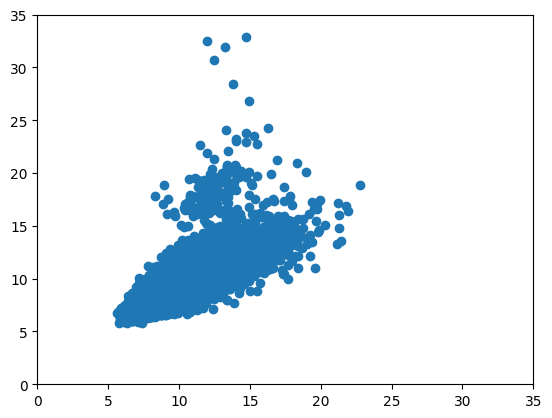

In [11]:
comp = pd.DataFrame({'pred': pred_y, 'true': tst_y})
plt.scatter(comp['pred']*100, comp['true']*100)
plt.xlim(0, 35)
plt.ylim(0, 35)

In [12]:
# function to get the predicted error
def get_pred_err(X):
    pred_y_list = []
    for model in err_models:
        pred_y = model.predict(X)
        pred_y_list.append(pred_y)
    return np.array(pred_y_list).mean(axis=0)

In [13]:
get_pred_err(test_x[:10])

array([0.07534139, 0.07392092, 0.09695672, 0.07746577, 0.11598435,
       0.08316099, 0.09990292, 0.08861711, 0.07747449, 0.10134984])

# Get the params and flops

In fact, in neural architecture search problems, the number of parameters and flops is not an expensive task and can be obtained directly.

In [14]:
# ignore this cell
## Nevertheless, the model is better because the \
## number of model parameters is evenly distributed than the accuracy

# def aux_flops(train_x, train_y):
def aux_params(train_x, train_y):
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from catboost import CatBoostRegressor, Pool
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=2023)

    models, errs = [], []
    X, y = train_x, train_y
    for train_idx, test_idx in kfold.split(X, y):
        model = CatBoostRegressor(iterations=10000, learning_rate=0.1, depth=6, random_seed=2023,
                                loss_function='RMSE', verbose=True, early_stopping_rounds=1000)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train, eval_set=Pool(X_test, y_test), use_best_model=True, verbose=500)
        
        y_pred = model.predict(X_test)
        models.append(model)
        
        err = mean_squared_error(y_test, y_pred)
        errs.append(err)

    return models, errs

In [15]:
# obtain the objectives values on params and flops
utopian = benchmark.utopian_point
nadir = benchmark.nadir_point
def get_pred_params_direct(X):
    return benchmark.evaluate(X)[:, 1]* (nadir[1] - utopian[1]) + utopian[1]
def get_pred_flops_direct(X):
    return benchmark.evaluate(X)[:, 2]* (nadir[2] - utopian[2]) + utopian[2]

In [16]:
real_param = get_pred_params_direct(test_x[:10])
real_param

array([ 5793546., 21220234., 14000266.,  6230410.,  1700385., 14000266.,
        4863626.,  2943654., 13836426.,  4166026.])

# A binary classifier to filter good architectures

In [17]:
train_x, train_y = X[:train_len], y[:train_len]
test_x, test_y = X[train_len:], y[train_len:]
print('train data shape: ', train_x.shape, '\ntest data shape: ', test_x.shape)

# prediction accuracy greater or less than 91%
trn_x = train_x
trn_y = np.array([i['err'] for i in train_y])
trn_y = np.array([1 if i <= 0.09 else 0 for i in trn_y])
tst_x = test_x
tst_y = np.array([i['err'] for i in test_y])
tst_y = np.array([1 if i <=0.09 else 0 for i in tst_y])

train data shape:  (5000, 26) 
test data shape:  (12384, 26)


In [18]:
# train binary CatBoostClassifier
def aux(train_x, train_y):
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from catboost import CatBoostRegressor, Pool, CatBoostClassifier
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=2023)

    models, accs = [], []
    X, y = train_x, train_y
    for train_idx, test_idx in kfold.split(X, y):
        model = CatBoostClassifier(iterations=10000, learning_rate=0.1, depth=6, random_seed=2023,
                                    early_stopping_rounds=500, loss_function='Logloss')
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train, eval_set=Pool(X_test, y_test), use_best_model=True, verbose=500)
        
        y_pred = model.predict(X_test)
        models.append(model)
        accs.append((y_pred == y_test).mean())

    return models, accs

In [19]:
pd_91_models, accs = aux(trn_x, trn_y)

0:	learn: 0.6288240	test: 0.6325114	best: 0.6325114 (0)	total: 4.98ms	remaining: 49.8s
500:	learn: 0.0309594	test: 0.2845988	best: 0.2768408 (306)	total: 1.41s	remaining: 26.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.276840756
bestIteration = 306

Shrink model to first 307 iterations.
0:	learn: 0.6231335	test: 0.6283376	best: 0.6283376 (0)	total: 4.12ms	remaining: 41.2s
500:	learn: 0.0302722	test: 0.2737765	best: 0.2669083 (342)	total: 1.4s	remaining: 26.6s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2669083136
bestIteration = 342

Shrink model to first 343 iterations.
0:	learn: 0.6246431	test: 0.6248960	best: 0.6248960 (0)	total: 4.7ms	remaining: 47s
500:	learn: 0.0303148	test: 0.2850805	best: 0.2740014 (334)	total: 1.42s	remaining: 26.9s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2740014113
bestIteration = 334

Shrink model to first 335 iterations.
0:	learn: 0.6238164	test: 0.6282048	best: 0.6282048 (0)	t

In [20]:
accs # about 90% 

[0.874, 0.873, 0.883, 0.892, 0.895]

In [21]:
# function to get the predicted category
def pd_X_more_than_91(X):
    pred_y_list = []
    for model in pd_91_models:
        pred_y = model.predict(X)
        pred_y_list.append(pred_y)
    return np.around(np.array(pred_y_list).mean(axis=0))

In [22]:
pd_X_more_than_91(train_x[:10])

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

# Combine models to predict the performance

In [23]:
pd_X = pd_X_more_than_91(test_x)
filter_x = test_x[pd_X == 1]
filter_y = np.array(test_y)[pd_X == 1]
y_err = np.array([i['err'] for i in filter_y])

In [24]:
pred_y = get_pred_err(filter_x)
mse_err = mean_squared_error(y_err, pred_y)
mae_err = mean_absolute_error(y_err, pred_y)
print('mse_err: ', mse_err, '\nmae_err: ', mae_err)

mse_err:  0.0001272292488564501 
mae_err:  0.008091884952317416


In [25]:
# get acc for only one arch
def get_end_acc(X):
    pd = pd_X_more_than_91(X)
    if pd == 1:
        return 1-get_pred_err(X)
    else:
        return None

In [26]:
print(get_end_acc(train_x[0]))

None


final performance using two predictors

mse_err:  0.0001186062031939344 

mae_err:  0.007592596438031209

# local search for entire search space

In [27]:
# load all arch representations in nasbench101, ref https://github.com/ultmaster/neuralpredictor.pytorch
nasbench_d = './'
with h5py.File(nasbench_d+"nasbench.hdf5", mode="r") as f:
    total_count = len(f["hash"][()])
    operations = f["operations"][()]
    trainable_parameters = f["trainable_parameters"][()]
    metrics = f["metrics"][()]
    adjacency = f["adjacency"][()]
    hash = f["hash"][()]
hashs = [h.decode() for h in hash]

In [28]:
def get_real_arch_info(hash):
    idx = hashs.index(hash)
    return operations[idx], trainable_parameters[idx], metrics[idx], adjacency[idx]

## Combine the existing archs

In [29]:
# read the existing archs in evolutionary algorithm
d = './exist_pops/'
h_f = pickle.load(open(d+'hashs_fitness_{:02d}.pkl'.format(args.run), 'rb'))
had_hashs =  np.array(h_f['hashs'])
had_fitness = np.array(h_f['fitness'])

# get the validation times
remains = 10000 - len(had_hashs)

train_had_hashs = problem._get_hash_x(train_x)

all_had_hashs = {k:True for k in had_hashs}
all_had_hashs.update({k:True for k in train_had_hashs})
topklen = 10000 - len(all_had_hashs)

In [30]:
print("base hv: " ,benchmark.calc_perf_indicator_fitness(had_fitness, 'hv'))

base hv:  0.9347493075666335


In [31]:
print(topklen, '\t wait to search')

4625 	 wait to search


## Traverse the entire search space

In [32]:
utopian_point = benchmark.utopian_point
nadir_point = benchmark.nadir_point
# get the denormalized fitness
def get_baseline_fitness(fitness):
    return fitness * (nadir_point - utopian_point) + utopian_point

In [33]:
x = train_x[0]
get_pred_params_direct([x])[0]

882570.0

In [34]:
num_vertices = 7
edge_spots_idx = np.triu_indices(num_vertices, 1)
def get_X(matrix, ops):
    matrix, ops = matrix.copy(), ops.copy()
    end_idx = np.where(ops == -2)[0][0]
    # print(end_idx)
    if end_idx != 6:
        matrix[:, 6] = matrix[:, end_idx]
        matrix[:, end_idx] = 0
    x_edge = matrix[edge_spots_idx]
    ops[end_idx] = 0
    fine_ops = ops[1:-1]
    # print(fine_ops)
    return np.concatenate((x_edge, fine_ops)).astype(int)  
# get_X(matrix, operations[0])

In [35]:
from tqdm import tqdm
rank_base = []
rank_X_list = []
rank_hashs = []
preds = []
for i, (matrix, ops, h) in  tqdm(enumerate(zip(adjacency, operations, hashs)), total=len(hashs)):
    # if i > 20000: break # remove this line to search all archs
    
    # map matrix and ops to X
    x = get_X(matrix, ops)
    
    # double check the hash
    x_hash = problem._get_hash_x([x])[0]
    assert x_hash == h
    if h in all_had_hashs:
        continue
    
    # only consider the archs with acc greater than 0.91
    pred_acc = get_end_acc(x)
    if pred_acc == None: continue
    
    # baseline_fitness = benchmark.evaluate([X], true_eval=True)
    # baseline_info = get_baseline_fitness(baseline_fitness)

    # print('real_acc: ', real_acc, '\tpred_err: ', pred_acc, '\t baseline acc', 1-baseline_info[0])
    # print('real_param: ', real_info[1], '\tpred_param: ', param[0])

    param = get_pred_params_direct([x])[0]
    
    # rank scheme
    norm_pred = benchmark.normalize(np.array([1-pred_acc, param]))
    
    preds.append(norm_pred)
    rank_base.append(norm_pred.sum())
    rank_X_list.append(x)
    rank_hashs.append(h)

  5%|▍         | 20001/423624 [01:49<36:42, 183.29it/s]  


In [36]:
preds[:5]

[array([0.27874231, 0.25864663]),
 array([0.45206984, 0.17549666]),
 array([0.42609075, 0.10875645]),
 array([0.24968335, 0.65196824]),
 array([0.31040612, 0.08854002])]

In [37]:
rank_base[:5]

[0.5373889458205303,
 0.6275664949804315,
 0.5348471992956904,
 0.9016515863882761,
 0.39894614519817184]

In [38]:
topk = sorted(zip(rank_base, rank_X_list), key=lambda x:x[0])[:topklen]

In [39]:
# get topk and train fitness
topk_X = np.array([i[1] for i in topk])
need_X = np.concatenate((train_x, topk_X))
print('need_X.shape: ', need_X.shape)
topk_fitness = []
for i, X in enumerate(need_X):
    baseline_fitness = benchmark.evaluate([X], true_eval=True)
    baseline_info = get_baseline_fitness(baseline_fitness)[0]
    topk_fitness.append(baseline_info)
topk_fitness = np.array(topk_fitness)
topk_fitness = benchmark.normalize(topk_fitness) # little redundant
topk_fitness.shape

need_X.shape:  (9625, 26)


(9625, 2)

In [40]:
# get all fitness
all_fitness = np.concatenate((topk_fitness, had_fitness))

all_fitness.shape

(10529, 2)

In [41]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
nd_front = NonDominatedSorting().do(all_fitness, only_non_dominated_front=True)
need_fitness = all_fitness[nd_front]
print(len(nd_front), ' front')

33  front


In [42]:
HV = benchmark.calc_perf_indicator_fitness(need_fitness, 'hv')
IGD = benchmark.calc_perf_indicator_fitness(need_fitness, 'igd')
print('HV: ', HV, '\t IGD: ', IGD)

HV:  0.9398536042624867 	 IGD:  0.018755044420218935


In [43]:
import json
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
run_stats = {'run': args.run}
run_stats['HV'] = HV
run_stats['IGD'] = IGD
run_stats['F'] = need_fitness.tolist()
d = './'
with open(d + 'res_{:02d}.json'.format(args.run), 'w') as fp:
    json.dump(run_stats, fp, indent=4, cls=NumpyEncoder)
run_stats

{'run': 2,
 'HV': 0.9398536042624867,
 'IGD': 0.018755044420218935,
 'F': [[0.6493776322100714, 0.008828995358913965],
  [0.868603036330904, 0.004090516084791747],
  [0.5176349715324682, 0.020118660743567576],
  [0.017980771426989943, 0.9677767508422528],
  [0.7053941285420822, 0.006783737316518092],
  [0.5888658401352987, 0.014881010057342754],
  [0.21922540412083216, 0.035731393418999634],
  [0.6061548060012181, 0.011295566123053378],
  [0.532157538242217, 0.01765799071782793],
  [0.8993774778810505, 0.0022919710205420232],
  [0.06535299059807025, 0.12896023399222842],
  [0.5639694823619414, 0.014933060781332299],
  [0.283195195140817, 0.026902398060085667],
  [0.05636239911254641, 0.19453405285073988],
  [0.5463348194875165, 0.015612732675432058],
  [0.40594747010492555, 0.02216391878596345],
  [0.7410095628434974, 0.005877414954831401],
  [0.10511761208968325, 0.0626337914790853],
  [0.04633471660150211, 0.20000397523429037],
  [0.03941913025513508, 0.20810152748377608],
  [0.03250